In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings, os
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras 

In [3]:
tf.__version__

'2.12.0'

In [12]:
# hyperparameters

img_size=512
img_channel=3

epoch=50
#batch_size = 1 * strategy.num_replicas_in_sync

kernel_initializer = keras.initializers.GlorotNormal(seed=4)
activation = 'relu'

In [13]:
def convBlock(filters, kernel, kernel_initializer, activation, name=None):
    
    if name is None:
        name = "convBlock" + str(backend.get_uid("convBlock"))
    
    def layer(input):
        c1 = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel, padding='same',
            kernel_initializer=kernel_initializer, name=name+'_conv')(input)
        c1 = tf.keras.layers.BatchNormalization(name=name+'_batch')(c1)
        c1 = tf.keras.layers.Activation(activation, name=name+'_active')(c1)
        return c1
    
    return layer

In [14]:
def dconvBlock(filters, kernel, kernel_initializer, activation, name=None):
    
    if name is None:
        name = "dconvBlock" + str(backend.get_uid("dconvBlock"))
    
    def layer(input):
        d1 = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel, padding='same',
            kernel_initializer=kernel_initializer, name=name+'_conv')(input)
        d1 = tf.keras.layers.BatchNormalization(name=name+'_batch')(d1)
        d1 = tf.keras.layers.Activation(activation, name=name+'_active')(d1)
        return d1
    
    return layer

In [15]:
def model_CASNET(activation, kernel_initializer, kernel_size):

    # Input
    input = tf.keras.Input(shape=(img_size, img_size, img_channel), name='images_input')
    x = input

    # Network 1 - Road Detection
    ## Encoder

    nfilters = [64, 128, 256, 512]
    for fmap in nfilters:
        x = convBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = convBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')(x)

    ## Decoder
    for fmap in reversed(nfilters):
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(x)
        x = dconvBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = dconvBlock(fmap, kernel_size, kernel_initializer, activation)(x)
    
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(1,1),
                                        kernel_initializer=kernel_initializer,activation=None,)(x)

    mask_op = tf.keras.layers.Activation('sigmoid', name='road', dtype=tf.float32)(x)

    # Network 2
    # ENCODER
    for fmap in nfilters[:-1]:
        x = convBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = convBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')(x)

    # DECODER   
    for fmap in reversed(nfilters[:-1]):
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation='bilinear')(x)
        x = dconvBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        x = dconvBlock(fmap, kernel_size, kernel_initializer, activation)(x)
        
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(1,1),
                                                   kernel_initializer=kernel_initializer,activation=None, )(x)

    centerline_op = tf.keras.layers.Activation('sigmoid', name='centerline', dtype=tf.float32)(x)

    model = tf.keras.Model(
        inputs={'images': input},
        outputs={'mask': mask_op, 'centerline': centerline_op},
        name='CasNet')
    
    return model

In [16]:
model = model_CASNET(activation=activation, kernel_initializer=kernel_initializer, kernel_size=3)
model_CASNET.summary()

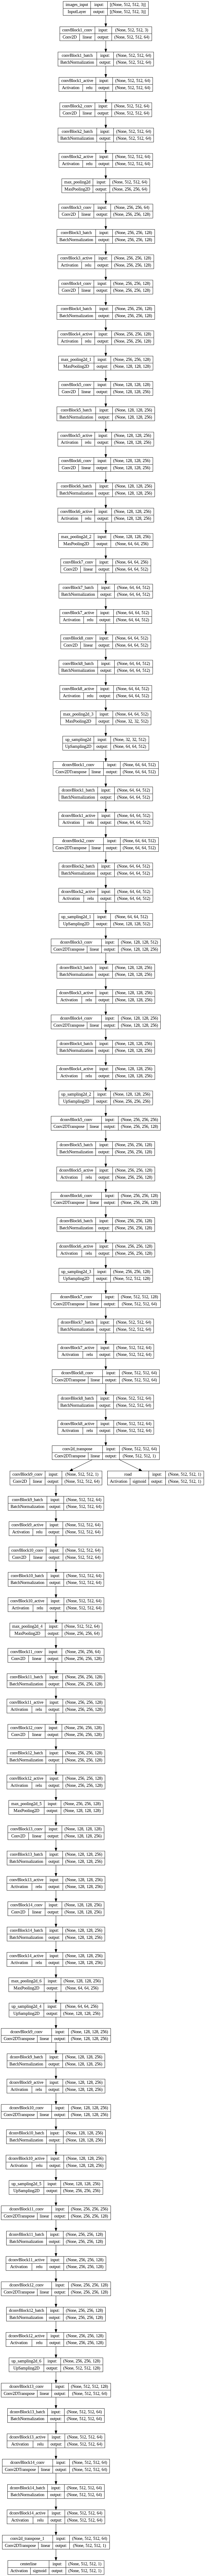

In [17]:
# plot
tf.keras.utils.plot_model(model, to_file='casnet_model.png', show_shapes=True, expand_nested=True, show_layer_activations=True)